In [1]:
import os
import torch

In [2]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

In [4]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7


In [5]:
data  =dataset[0]
print(data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [6]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training = self.training)
        x = self.conv2(x, edge_index)
        return x


In [19]:
model = GCN(hidden_channels=128) # Đổi 128, 256, ...
print(model)

GCN(
  (conv1): GCNConv(1433, 128)
  (conv2): GCNConv(128, 7)
)


In [20]:
# Chua train, ve vissualize xem model no ngoc nhu nao
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

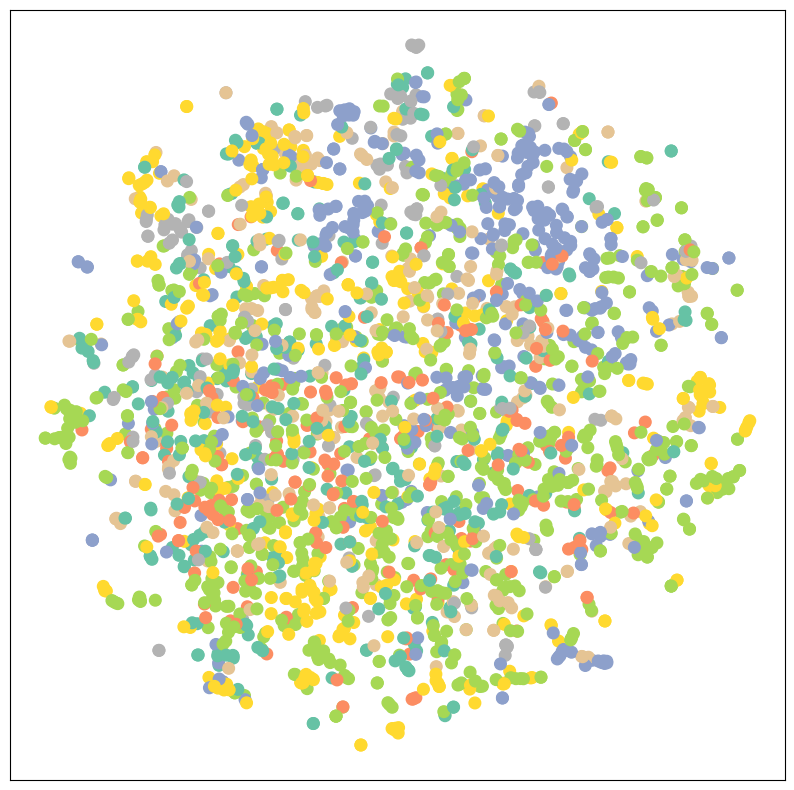

In [21]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [22]:
model = GCN(hidden_channels=128)
opt = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay = 5e-4)
cr = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    opt.zero_grad()
    out = model(data.x, data.edge_index)
    loss = cr(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    opt.step()
    return loss

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_acc


In [29]:
# Train
n_epochs = 400
for epoch in range(1, n_epochs+1):
    loss =train()
    print("Epoch {}. Loss = {}".format(epoch, loss))

Epoch 1. Loss = 0.12691345810890198
Epoch 2. Loss = 0.12414807081222534
Epoch 3. Loss = 0.12282154709100723
Epoch 4. Loss = 0.12386541068553925
Epoch 5. Loss = 0.125461608171463
Epoch 6. Loss = 0.12083902209997177
Epoch 7. Loss = 0.12171562761068344
Epoch 8. Loss = 0.12285168468952179
Epoch 9. Loss = 0.13684037327766418
Epoch 10. Loss = 0.12270708382129669
Epoch 11. Loss = 0.12209456413984299
Epoch 12. Loss = 0.12803736329078674
Epoch 13. Loss = 0.12580512464046478
Epoch 14. Loss = 0.13005706667900085
Epoch 15. Loss = 0.12071052193641663
Epoch 16. Loss = 0.1298963725566864
Epoch 17. Loss = 0.12835735082626343
Epoch 18. Loss = 0.12771321833133698
Epoch 19. Loss = 0.13747097551822662
Epoch 20. Loss = 0.1290588527917862
Epoch 21. Loss = 0.1174745038151741
Epoch 22. Loss = 0.13049480319023132
Epoch 23. Loss = 0.12642137706279755
Epoch 24. Loss = 0.12073934823274612
Epoch 25. Loss = 0.13168179988861084
Epoch 26. Loss = 0.12540455162525177
Epoch 27. Loss = 0.1254255175590515
Epoch 28. Loss =

In [30]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')


Test Accuracy: 0.8140


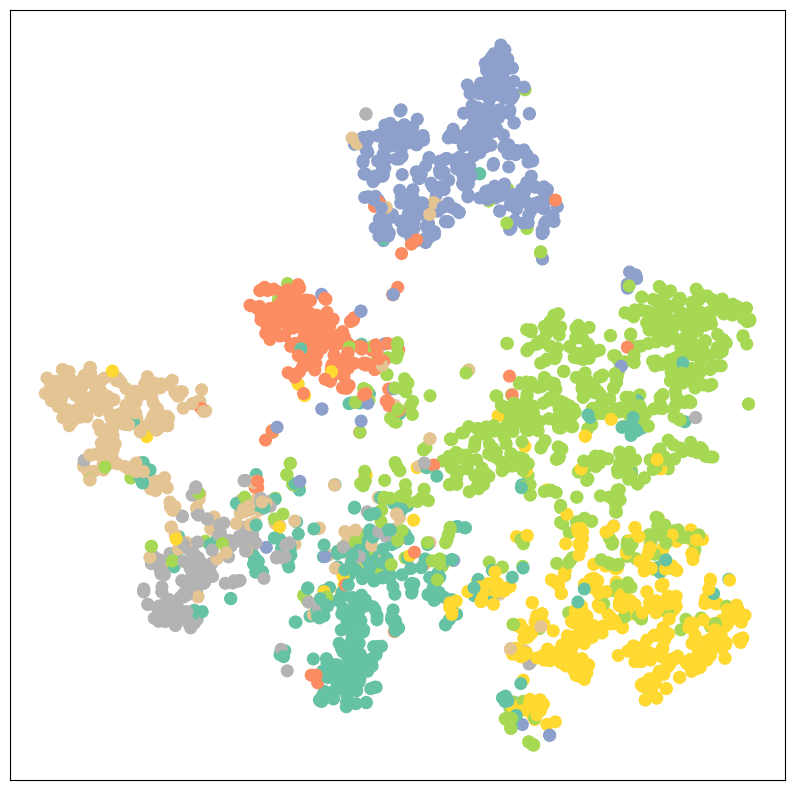

In [31]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [34]:
print(data.y[10], out[10].argmax())

tensor(0) tensor(0)
